# Multimodal Network

Create GNN for each of the dimensions and later combine them into a single network.

1. Each dimension is a separate graph and gets its own GNN.
2. Dimensions are connected in a MLP layer.

Add the Gini value as a node-feature and masking it to prevent data-leakage.

#### Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import TensorDataset, random_split
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import os
import country_converter as coco
import functools
import os

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.chdir('/home/jovyan/dlss-project')
print("Current working directory:", os.getcwd())

cuda
Current working directory: /home/jovyan/dlss-project


## Data

In [2]:
path_geo_edges = "data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "data_collection/political/data/edge_features.parquet"
path_pol_nodes = "data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "data_collection/culture/culture_edges.parquet"
path_cult_nodes = "data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "data_collection/economics/edges_economics.parquet"
path_eco_nodes = "data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

path_gini = "data_collection/gini.parquet"
df_gini = pd.read_parquet(path_gini)
df_gini = df_gini[df_gini['year'].between(2000, 2022)].reset_index(drop=True)

In [ ]:
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric

@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)

def df_preparation(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Pre-filter dataframes
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)

    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year is int before unique extraction
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop any rows where mapping failed (shouldn't if filters were correct)
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast country_id to int
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)
    
    edge_features_cols = [
        col for col in edge_df.columns
        if col not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    node_features_cols = [
        col for col in node_df.columns
        if col not in [node_country_col, year_col, 'country_id']
    ]
    
    edge_df_processed = edge_df.copy()[['country_id_a', 'country_id_b', year_col] + edge_features_cols]
    node_df_processed = node_df.copy()[['country_id', year_col] + node_features_cols]
    
    return node_df_processed, edge_df_processed

def preprocess_gini(df_gini, year_col='year', country_col='country', gini_col='gini'):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Filter Gini data for UN countries
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    
    # Convert country codes to UN numeric
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    
    # Drop rows with NaN country_id
    df_gini = df_gini.dropna(subset=['country_id'])
    
    # Normalize Gini values to [0, 1] range for each year
    df_gini[gini_col] = df_gini[gini_col] / 100
    
    # create mask column to indicate if country exists in this year
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0  # Fill NaN Gini values with 0
    
    return df_gini[['country_id', year_col, gini_col, 'exists']].copy()

def create_data_yearly(node_df, edge_df, year, mask_col, year_col='year',):
        
    edge_df_year = edge_df[edge_df[year_col] == year]
    node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
    
    # drop dupicate rows in node_df_year
    node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
            
    # --- Edge features ---
    edge_features_cols = [
        col for col in edge_df_year.columns
        if col not in ['country_id_a', 'country_id_b', year_col]
    ]
    edge_features_df = edge_df_year[edge_features_cols].copy()
    
    # Coerce all edge feature columns to numeric, fill NaN with 0
    edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # --- Node features ---
    node_features_cols = [
        col for col in node_df_year.columns
        if col not in ['country_id', year_col, mask_col]
    ]
    # TODO: maybe also remove 'exists' column
        
    # Ensure node_df_year is sorted by country_id and align features accordingly
    node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
    # select only feature columns
    node_df_year_features = node_df_year_sorted[node_features_cols].copy()
    
    mask_col_tensor = torch.tensor(node_df_year_sorted[mask_col].values, dtype=torch.float32)
    
    country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)
    
    # --- Tensor creation ---
    edge_features_array = edge_features_df.values.astype(np.float32)
    edge_attr = torch.from_numpy(edge_features_array)

    
    node_df_year_features = node_df_year_features.apply(pd.to_numeric, errors='coerce').fillna(0)
    node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
    
    
    # Build a mapping from country_id to its position in the sorted node list
    country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
    
    # Map edge indices to positions in the sorted node list
    edge_index = torch.tensor(
        [
        edge_df_year['country_id_a'].map(country_id_to_pos).values,
        edge_df_year['country_id_b'].map(country_id_to_pos).values
        ],
        dtype=torch.long
    )
    data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id = country_id_tensor, mask=mask_col_tensor)
    
    return data

def scale_data(node_df, edge_df, node_features_cols, edge_feature_cols):
    """
    Scale node and edge dataframes using StandardScaler.
    """
    # apply standardization to node features
    node_scaler = StandardScaler()
    edge_scaler = StandardScaler()
    
    # fit standard scaler on train set
    
    # create subset of only training rows to fit scaler
    node_df_train_subset = node_df[node_df['train_mask'] == 1]
    node_scaler.fit(node_df_train_subset[node_features_cols])
    
    # filter edge_df to only include training countries
    edge_df_train_subset = edge_df[edge_df['country_id_a'].isin(node_df_train_subset['country_id']) & 
                                   edge_df['country_id_b'].isin(node_df_train_subset['country_id'])]
    edge_scaler.fit(edge_df_train_subset[edge_feature_cols])
    
    # apply scaler to all node dataframes
    node_df[node_features_cols] = node_scaler.transform(node_df[node_features_cols])
    edge_df[edge_feature_cols] = edge_scaler.transform(edge_df[edge_feature_cols])
    
    return node_df, edge_df

def create_network_data(node_df, edge_df, gini_df):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()
    
    # convert boolean columns to int
    bool_cols_nodes = node_df.select_dtypes(include='bool').columns
    if len(bool_cols_nodes) > 0:
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)
    bool_cols_edges = edge_df.select_dtypes(include='bool').columns
    if len(bool_cols_edges) > 0:
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    
    # fill in all missing countries with 0 values for the years from 2000 to 2022
    all_years = range(2000, 2023)
    all_countries = uno_unnumeric_codes
    
    # Create a MultiIndex of all combinations
    full_index = pd.MultiIndex.from_product([all_countries, all_years], names=['country_id', 'year'])
    node_df = node_df.set_index(['country_id', 'year'])
    node_df = node_df.reindex(full_index, fill_value=0).reset_index()
        
    # Fill missing feature columns with 0 (if any NaNs)
    node_features_cols = [col for col in node_df.columns if col not in ['country_id', 'year']]
    node_df[node_features_cols] = node_df[node_features_cols].fillna(0)
    
    edge_feature_cols = [col for col in edge_df.columns if col not in ['country_id_a', 'country_id_b', 'year']]
    
    # merge node_df with gini_df
    node_df_merged = node_df.merge(gini_df, on=['country_id', 'year'])
    
    node_df_merged, edge_df = scale_data(node_df_merged, edge_df, node_features_cols, edge_feature_cols)
    
    # generate train, val and test set.
    # set gini to 0 at respected masks
    
    node_df_train = node_df_merged.copy().drop(columns=['val_mask', 'test_mask'], errors='ignore')
    node_df_val = node_df_merged.copy().drop(columns=['train_mask', 'test_mask'], errors='ignore')
    node_df_test = node_df_merged.copy().drop(columns=['train_mask', 'val_mask'], errors='ignore')
    
    # set gini to 0 where train_mask is 1
    node_df_train.loc[gini_df['train_mask'] == 1, 'gini'] = 0
    node_df_val.loc[gini_df['val_mask'] == 1, 'gini'] = 0
    node_df_test.loc[gini_df['test_mask'] == 1, 'gini'] = 0
    
    
    # limit years from 2000 to 2022
    years = [year for year in range(2000, 2023)]
    
    data_dict = {}
    # create data for each year
    
    for year in years:
        data_train = create_data_yearly(node_df_train, edge_df, year, 'train_mask', year_col='year')
        data_val = create_data_yearly(node_df_val, edge_df, year, 'val_mask', year_col='year')
        data_test = create_data_yearly(node_df_test, edge_df, year, 'test_mask', year_col='year')
        data_dict[year] = {
            'train': data_train,
            'val': data_val,
            'test': data_test
        }
    
    return data_dict

def create_gini_data(gini_df, year_col='year'):
    
    gini_dict = {}
    
    for year in range(2000, 2023):
        gini_df_year = gini_df[gini_df[year_col] == year].copy()

        # convert to tensor
        gini_tensor = torch.tensor(gini_df_year['gini'].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(gini_df_year['country_id'].values, dtype=torch.long)
        train_mask_tensor = torch.tensor(gini_df_year['train_mask'].values, dtype=torch.bool)
        val_mask_tensor = torch.tensor(gini_df_year['val_mask'].values, dtype=torch.bool)
        test_mask_tensor = torch.tensor(gini_df_year['test_mask'].values, dtype=torch.bool)
        
        
        
        gini_dict[year] = {
            'train': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=train_mask_tensor),
            'val': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=val_mask_tensor),
            'test': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=test_mask_tensor)
        }
        
    return gini_dict
            

def create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split all available (exists==1) rows in gini_df into train/val/test and create mask columns.
    Adds 'train_mask', 'val_mask', 'test_mask' columns to gini_df (0/1 values).
    """
    df = gini_df.copy()
    available_idx = df.index[df['exists'] == 1].tolist()
    train_idx, test_idx = train_test_split(available_idx, test_size=test_size, random_state=random_state)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_size, random_state=random_state)
    
    df['train_mask'] = 0
    df['val_mask'] = 0
    df['test_mask'] = 0
    df.loc[train_idx, 'train_mask'] = 1
    df.loc[val_idx, 'val_mask'] = 1
    df.loc[test_idx, 'test_mask'] = 1
    return df

def create_data(data_combined, gini_df):
    
    # create gini train, val and test masks
    # perform train-val-test split on gini_data for all available values
    
    gini_df = create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42)
    
    data_dict = {}
    
    for modality, data in data_combined.items():
        nodes = data['nodes']
        edges = data['edges']
        data_dict[modality] = create_network_data(nodes, edges, gini_df)
        
    # add gini data
    gini_data = create_gini_data(gini_df)
    data_dict['gini'] = gini_data
    
    data_dict_reform = {}
    # reform data_dict to have years as keys
    for year in range(2000, 2023):
        data_dict_reform[year] = {
            'political': data_dict['political'][year],
            'geography': data_dict['geography'][year],
            'culture': data_dict['culture'][year],
            'language': data_dict['language'][year],
            'economy': data_dict['economy'][year],
            'gini': gini_data[year]
        }
    
    # reform again to have train, val, test as subkeys -> data_dict_reform[year]['train'], data_dict_reform[year]['val'], data_dict_reform[year]['test']
    for year in data_dict_reform.keys():
        data_dict_reform[year] = {
            'train': {
                'political': data_dict_reform[year]['political']['train'],
                'geography': data_dict_reform[year]['geography']['train'],
                'culture': data_dict_reform[year]['culture']['train'],
                'language': data_dict_reform[year]['language']['train'],
                'economy': data_dict_reform[year]['economy']['train'],
                'gini': data_dict_reform[year]['gini']['train']
            },
            'val': {
                'political': data_dict_reform[year]['political']['val'],
                'geography': data_dict_reform[year]['geography']['val'],
                'culture': data_dict_reform[year]['culture']['val'],
                'language': data_dict_reform[year]['language']['val'],
                'economy': data_dict_reform[year]['economy']['val'],
                'gini': data_dict_reform[year]['gini']['val']
            },
            'test': {
                'political': data_dict_reform[year]['political']['test'],
                'geography': data_dict_reform[year]['geography']['test'],
                'culture': data_dict_reform[year]['culture']['test'],
                'language': data_dict_reform[year]['language']['test'],
                'economy': data_dict_reform[year]['economy']['test'],
                'gini': data_dict_reform[year]['gini']['test']
            }
        }
        
    return data_dict_reform

In [22]:
geo_nodes, geo_edges = df_preparation(df_geo_edges, df_geo_nodes, 
                        edge_country_a_col='iso_o', edge_country_b_col='iso_d',
                        node_country_col='code_3', year_col='year')

pol_nodes, pol_edges = df_preparation(df_pol_edges, df_pol_nodes,
                        edge_country_a_col='state1', edge_country_b_col='state2',
                        node_country_col='country', year_col='year')

cul_nodes, cul_edges = df_preparation(df_cult_edges, df_cult_nodes,
                        edge_country_a_col='ISO3_a', edge_country_b_col='ISO3_b',
                        node_country_col='ISO3', year_col='year')

lang_nodes, lang_edges = df_preparation(df_lang_edges, df_lang_nodes,
                        edge_country_a_col='country_a', edge_country_b_col='country_b',
                        node_country_col='ISO3', year_col='year')

eco_nodes, eco_edges = df_preparation(df_eco_edges, df_eco_nodes,
                        edge_country_a_col='src_ISO3', edge_country_b_col='tgt_ISO3',
                        node_country_col='ISO3', year_col='year')

data_combined = {
    'geography': {'nodes': geo_nodes, 'edges': geo_edges},
    'political': {'nodes': pol_nodes, 'edges': pol_edges},
    'culture': {'nodes': cul_nodes, 'edges': cul_edges},
    'language': {'nodes': lang_nodes, 'edges': lang_edges},
    'economy': {'nodes': eco_nodes, 'edges': eco_edges}
}

df_gini_processed = preprocess_gini(df_gini)

In [23]:
data_dict = create_data(data_combined, df_gini_processed)

In [6]:
data_dict[2000]['train']['political'].x

tensor([[-2.0361, -1.7419, -1.9230,  ..., -2.5128,  0.0000,  0.0000],
        [-0.7807, -0.5819, -0.7201,  ..., -1.0274,  0.0000,  0.0000],
        [-1.1020, -1.2743, -1.2865,  ..., -1.4988,  0.0000,  0.0000],
        ...,
        [-2.3089, -1.8205, -1.9838,  ..., -0.2482,  0.0000,  0.0000],
        [-1.3224, -1.3422, -1.4643,  ..., -1.3853,  0.0000,  0.0000],
        [-0.4780, -0.4534, -0.4815,  ..., -0.8735,  0.0000,  0.0000]])

In [24]:
# get the dimesions of each network: number of node_features, number of edge-features
network_dimesions = {
    'geography': {
        'node_features': data_dict[2000]['train']['geography'].x.shape[1],
        'edge_features': data_dict[2000]['train']['geography'].edge_attr.shape[1]
    },
    'political': {
        'node_features': data_dict[2000]['train']['political'].x.shape[1],
        'edge_features': data_dict[2000]['train']['political'].edge_attr.shape[1]
    },
    'culture': {
        'node_features': data_dict[2000]['train']['culture'].x.shape[1],
        'edge_features': data_dict[2000]['train']['culture'].edge_attr.shape[1]
    },
    'language': {
        'node_features': data_dict[2000]['train']['language'].x.shape[1],
        'edge_features': data_dict[2000]['train']['language'].edge_attr.shape[1]
    },
    'economy': {
        'node_features': data_dict[2000]['train']['economy'].x.shape[1],
        'edge_features': data_dict[2000]['train']['economy'].edge_attr.shape[1]
        },  # Placeholder for future economy data
}

In [25]:
network_dimesions

{'geography': {'node_features': 30, 'edge_features': 16},
 'political': {'node_features': 9, 'edge_features': 5},
 'culture': {'node_features': 8, 'edge_features': 11},
 'language': {'node_features': 9, 'edge_features': 2},
 'economy': {'node_features': 5, 'edge_features': 1}}

## Model Setup

In [178]:
# GNN model for each of the different networks
class DimensionModel(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_size=64, target_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.target_size = target_size
        self.convs = nn.ModuleList([GATv2Conv(self.num_node_features, self.hidden_size, edge_dim = num_edge_features),
                      GATv2Conv(self.hidden_size, self.hidden_size, edge_dim = num_edge_features)])
        # Add a fully connected layer after GNN
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden_size, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, self.hidden_size),
            nn.ReLU()
        )
        
    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        for conv in self.convs[:-1]:
            x = conv(x, edge_index, edge_attr=edge_attr)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.convs[-1](x, edge_index, edge_attr=edge_attr)
        x = self.mlp(x)  # Apply the fully connected layer
        return x
    
class MultiModalGNNModel(nn.Module):
    def __init__(self, 
                 input_dims,  # list of (num_node_features, num_edge_features) per modality
                 hidden_size=64,
                 final_output_size=1):
        super().__init__()
        
        self.geo_model = DimensionModel(input_dims['geography']['node_features'], 
                                        input_dims['geography']['edge_features'], hidden_size)
        self.pol_model = DimensionModel(input_dims['political']['node_features'], 
                                        input_dims['political']['edge_features'], hidden_size)
        self.cult_model = DimensionModel(input_dims['culture']['node_features'], 
                                        input_dims['culture']['edge_features'], hidden_size)
        self.lang_model = DimensionModel(input_dims['language']['node_features'], 
                                        input_dims['language']['edge_features'], hidden_size)
        self.eco_model = DimensionModel(input_dims['economy']['node_features'], 
                                        input_dims['economy']['edge_features'], hidden_size)

        self.fusion_input_size = hidden_size * len(input_dims.keys())

        self.mlp = nn.Sequential(
            nn.Linear(self.fusion_input_size, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, final_output_size)
        )

    def forward(self, data_dict):
        geo_emb = self.geo_model(data_dict['geography'])
        pol_emb = self.pol_model(data_dict['political'])
        cult_emb = self.cult_model(data_dict['culture'])
        lang_emb = self.lang_model(data_dict['language'])
        eco_emb = self.eco_model(data_dict['economy'])
        
        embeddings = [geo_emb, pol_emb, cult_emb, lang_emb, eco_emb]

        fused = torch.cat(embeddings, dim=-1)  # shape: [num_nodes, hidden_size * num_modalities]
        output = self.mlp(fused)               # shape: [num_nodes, final_output_size]
        return output


## Training Setup

In [179]:
class EarlyStopping:
    def __init__(self, patience=25, min_delta=0.0001, path='checkpoint.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.path = path  # Path to save the best model
        
        # remove model if path already exists
        if os.path.exists(path):
          os.remove(path)
          print(f"Removing existing model at: {path}")

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            if val_loss < self.best_loss:
                self.save_checkpoint(val_loss, model)
                self.best_loss = val_loss
                self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        torch.save(model.state_dict(), self.path)
        print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        
        
def train_gnn(epochs, model, optimizer, criterion, dataloader, early_stopper):    
    # Make sure device is defined
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the data and model to the device
    # data_dict = move_data_to_device(data_dict, device)

    # model = model.to(device)

    train_losses = []
    val_losses = []
    
    print("Starting training...")

    for epoch in range(epochs):
        model.train()
        train_loss_temp = 0
        val_loss_temp = 0
        num_batches = 0
        for data_dict in dataloader:
            # Training

            optimizer.zero_grad()

            # Forward pass on the entire graph
            output = model(data_dict['train'])
            mask = data_dict['train']['gini'].mask
            target = data_dict['train']['gini'].y
            
            output_masked = output[mask]
            target_masked = target[mask]

            # Calculate loss using only valid entries
            train_loss = criterion(output_masked, target_masked)

            # Backward pass
            train_loss.backward()
            optimizer.step()
            train_loss_temp += train_loss.item()
            
            num_batches += 1

        # Validation
            model.eval()
            with torch.no_grad():
                output = model(data_dict['val'])
                mask = data_dict['val']['gini'].mask
                target = data_dict['val']['gini'].y
                
                target_masked = target[mask]
                output_masked = output[mask]
                
                val_loss = criterion(output[mask], target[mask])
                val_loss_temp += val_loss.item()
        
        avg_train_loss = train_loss_temp / num_batches
        avg_val_loss = val_loss_temp / num_batches
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch: {epoch+1}, Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

        # Early stopping
        early_stopper(val_loss, model)
        if early_stopper.early_stop:
            print("Early stopping triggered.")
            break

    # Load the best model weights
    model.load_state_dict(torch.load(early_stopper.path))
    return train_losses, val_losses

## Training

In [180]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def move_data_dict_to_device(data_dict, device):
    moved = {}
    for k, v in data_dict.items():
        for k2, v2 in v.items():
            if isinstance(v2, Data):
                # Move Data object to device
                v[k2] = v2.to(device)
            elif isinstance(v2, torch.Tensor):
                # Move tensor to device
                v[k2] = v2.to(device)
            else:
                # Leave other types unchanged
                v[k2] = v2
        if hasattr(v, 'to'):
            moved[k] = v.to(device)
        else:
            moved[k] = v
    return moved

data_set = [data_dict[year] for year in data_dict.keys()]

data_set = [move_data_dict_to_device(d, device) for d in data_set]

data_loader = DataLoader(data_set, batch_size=3, shuffle=True)

In [181]:
next(iter(data_loader))['train']  # Check if DataLoader works

{'political': DataBatch(x=[579, 9], edge_index=[2, 3753], edge_attr=[3753, 5], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'geography': DataBatch(x=[579, 30], edge_index=[2, 102120], edge_attr=[102120, 16], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'culture': DataBatch(x=[579, 8], edge_index=[2, 25720], edge_attr=[25720, 11], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'language': DataBatch(x=[579, 9], edge_index=[2, 111168], edge_attr=[111168, 2], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'economy': DataBatch(x=[579, 5], edge_index=[2, 75832], edge_attr=[75832, 1], country_id=[579], mask=[579], batch=[579], ptr=[4]),
 'gini': DataBatch(y=[579, 1], country_id=[579], mask=[579])}

Removing existing model at: model_checkpoints/gan_gini_checkpoint.pt
Starting training...
Epoch: 1, Training Loss: 0.0768, Validation Loss: 0.0791
Validation loss decreased (0.079125 --> 0.079125).  Saving model ...
Epoch: 2, Training Loss: 0.0606, Validation Loss: 0.0639
Validation loss decreased (0.079125 --> 0.063923).  Saving model ...
Epoch: 3, Training Loss: 0.0553, Validation Loss: 0.0710
Epoch: 4, Training Loss: 0.0754, Validation Loss: 0.0469
Validation loss decreased (0.063923 --> 0.046895).  Saving model ...
Epoch: 5, Training Loss: 0.0602, Validation Loss: 0.0645
Epoch: 6, Training Loss: 0.1121, Validation Loss: 0.0990
Epoch: 7, Training Loss: 0.0497, Validation Loss: 0.0655
Epoch: 8, Training Loss: 0.0598, Validation Loss: 0.0592
Epoch: 9, Training Loss: 0.0464, Validation Loss: 0.0731
Epoch: 10, Training Loss: 0.0390, Validation Loss: 0.0515
Epoch: 11, Training Loss: 0.0499, Validation Loss: 0.0323
Validation loss decreased (0.046895 --> 0.032319).  Saving model ...
Epoch

Text(0.5, 1.0, 'Training Progress')

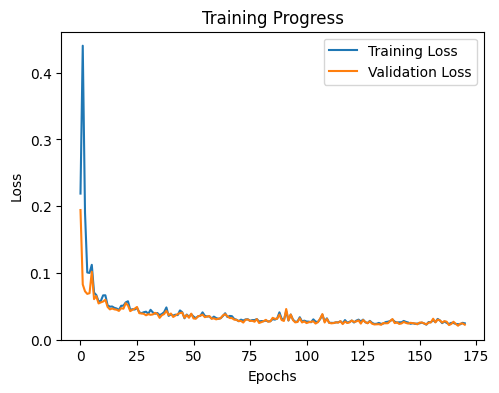

In [182]:
params = {
    'lr': 0.001,
    'weight_decay': 0.0001,
    'hidden_size': 48
}


gan_model = MultiModalGNNModel(
    input_dims=network_dimesions, hidden_size=params['hidden_size'])

gan_model = gan_model.to(device)

# criterion for regression task
criterion = nn.L1Loss() 

# Fix 7: Better optimizer settings for this problem
optimizer = optim.Adam(gan_model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])  # Lower LR and weight decay

# Initialize early stopping
early_stopper = EarlyStopping(patience=40, min_delta=0.00001, path='model_checkpoints/gan_gini_checkpoint.pt')

# Train the model
epochs = 600
train_losses_gan, val_losses_gan = train_gnn(epochs, gan_model, optimizer, criterion, data_loader, early_stopper)

# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses_gan, label='Training Loss')
plt.plot(val_losses_gan, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')

## Evaluation

In [183]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(model, dataloader, device):
    model.eval()
    all_true = []
    all_pred = []
    with torch.no_grad():
        for data_dict in dataloader:
            output = model(data_dict['test'])
            mask = data_dict['test']['gini'].mask
            true = data_dict['test']['gini'].y[mask==1].cpu().numpy()
            pred = output[mask==1].cpu().numpy()
            all_true.append(true)
            all_pred.append(pred)
    # Concatenate results from all batches
    all_true = np.concatenate(all_true, axis=0)
    all_pred = np.concatenate(all_pred, axis=0)
    
    # Calculate mean percentage error (MPE)
    mpe = np.mean((all_true - all_pred) / all_true) * 100
    # Calculate regression metrics
    mae = mean_absolute_error(all_true, all_pred)
    rmse = np.sqrt(mean_squared_error(all_true, all_pred))
    r2 = r2_score(all_true, all_pred)

    print(f"Mean Percentage Error (MPE): {mpe:.2f}%")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R^2 Score: {r2:.4f}")

    # Visualization: Predicted vs True
    plt.figure(figsize=(6, 6))
    plt.scatter(all_true, all_pred, alpha=0.5)
    plt.plot([all_true.min(), all_true.max()], [all_true.min(), all_true.max()], 'r--')
    plt.xlabel('True GINI')
    plt.ylabel('Predicted GINI')
    plt.title('Predicted vs True GINI (Test Set)')
    plt.tight_layout()
    plt.show()

    # Visualization: Residuals
    residuals = all_true - all_pred
    plt.figure(figsize=(6, 4))
    plt.hist(residuals, bins=30, alpha=0.7)
    plt.xlabel('Residual (True - Predicted)')
    plt.ylabel('Frequency')
    plt.title('Residuals Distribution')
    plt.tight_layout()
    plt.show()
    
    return all_true, all_pred

Mean Percentage Error (MPE): -1.48%
Mean Absolute Error (MAE): 0.0231
Root Mean Squared Error (RMSE): 0.0329
R^2 Score: 0.8502


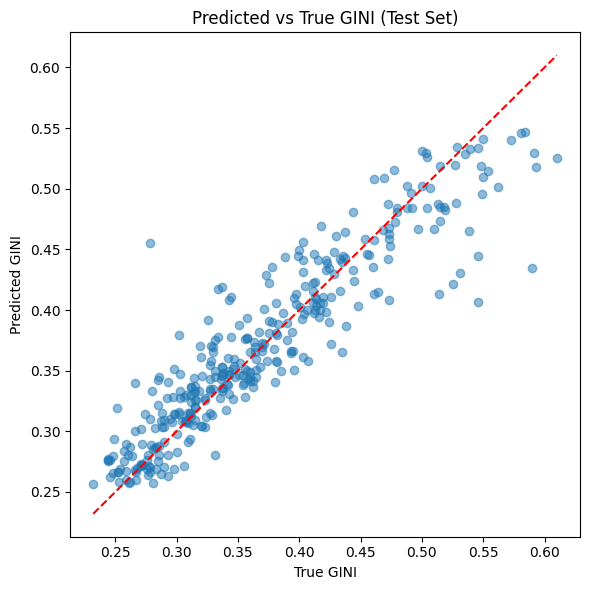

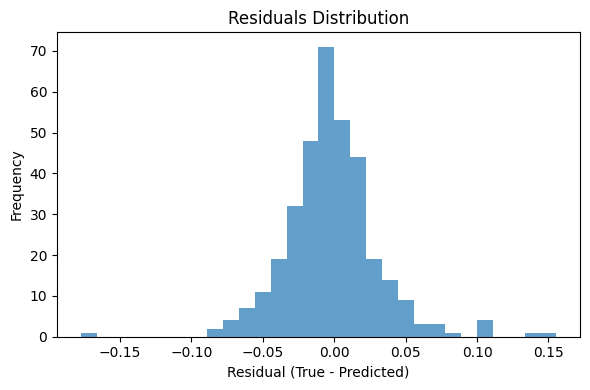

In [184]:
true, pred = evaluate_model(gan_model, data_loader, device)

In [185]:
true

array([[0.251],
       [0.26 ],
       [0.375],
       [0.244],
       [0.371],
       [0.535],
       [0.473],
       [0.271],
       [0.324],
       [0.292],
       [0.354],
       [0.337],
       [0.29 ],
       [0.334],
       [0.331],
       [0.528],
       [0.515],
       [0.477],
       [0.293],
       [0.371],
       [0.531],
       [0.538],
       [0.593],
       [0.581],
       [0.518],
       [0.497],
       [0.519],
       [0.381],
       [0.298],
       [0.37 ],
       [0.326],
       [0.319],
       [0.311],
       [0.413],
       [0.414],
       [0.404],
       [0.33 ],
       [0.272],
       [0.321],
       [0.356],
       [0.323],
       [0.286],
       [0.343],
       [0.507],
       [0.36 ],
       [0.37 ],
       [0.331],
       [0.417],
       [0.296],
       [0.422],
       [0.278],
       [0.461],
       [0.461],
       [0.418],
       [0.271],
       [0.39 ],
       [0.311],
       [0.424],
       [0.337],
       [0.268],
       [0.282],
       [0.274],
       [

In [186]:
data_dict[2020]['test']['gini'].mask

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False,  True, False, False, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False,  True,  True, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, 

In [187]:
mask = data_dict[2020]['test']['gini'].mask
data_dict[2020]['test']['gini'].y.flatten()[mask]

tensor([0.2510, 0.2600, 0.3750, 0.2440, 0.3710, 0.5350, 0.4730, 0.2710, 0.3240,
        0.2920, 0.3540, 0.3370], device='cuda:0')

In [188]:
mask.dtype

torch.bool